<a href="https://colab.research.google.com/github/gbpereira/time_prediction/blob/main/regressores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Técnicas tradicionais de aprendizado de máquina supervisionado em tarefas de regressão

# Dependências

In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# sklearn
import sklearn.tree as tree
import sklearn.ensemble as ensemble
import sklearn.svm as svm
import sklearn.feature_selection as feature_selection
import sklearn.metrics as sklearn_metrics

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from datetime import datetime, timedelta

%matplotlib inline

# Preparação dos dados

Leitura dos dados

In [3]:
url = 'https://raw.githubusercontent.com/gbpereira/time_prediction/main/data/dataset.csv'
dataset = pd.read_csv(url)
dataset.head()

,quantity,holiday,time_elapsed,ongoing_orders,waze_avg_time,waze_avg_distance,datetime,reseller
0,1,False,18.459633,1,8.583333,3.136,2022-09-01 10:50:00,B
1,1,False,31.472517,0,11.183333,5.397,2022-09-01 13:21:00,A
2,1,False,29.343333,0,8.400000,3.123,2022-09-01 17:51:00,A
3,1,False,46.103800,0,12.733333,4.536,2022-09-01 18:35:00,B
4,1,False,20.950450,0,8.866667,3.524,2022-09-02 10:13:00,D


In [4]:
dataset.describe(include='all')

,quantity,holiday,time_elapsed,ongoing_orders,waze_avg_time,waze_avg_distance,datetime,reseller
count,8421.000000,8421,8421.000000,8421.000000,8421.000000,8421.000000,8421,8421
unique,NaN,2,NaN,NaN,NaN,NaN,8298,6
top,NaN,False,NaN,NaN,NaN,NaN,2023-02-19 12:29:00,A
freq,NaN,8182,NaN,NaN,NaN,NaN,3,3522
mean,1.038950,NaN,34.273617,1.107469,12.047387,4.862416,NaN,NaN
std,0.213895,NaN,15.534184,1.328106,5.398807,2.490692,NaN,NaN
min,1.000000,NaN,4.435383,0.000000,1.983333,0.717000,NaN,NaN
25%,1.000000,NaN,23.692417,0.000000,8.366667,3.240000,NaN,NaN
50%,1.000000,NaN,31.131583,1.000000,11.233333,4.331000,NaN,NaN
75%,1.000000,NaN,40.984167,2.000000,14.200000,5.697000,NaN,NaN


Conversão de hora para formato **decimal**

In [5]:
# funcoes auxiliares
def hour_to_dec(time):
  hour, minutes = str(time).split(':')
  return round(float(hour) + float(minutes) / 60.0, 2)

def get_plain_hour(string):
  timestamp = datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
  return timestamp.strftime('%H:%M')

def get_date(string):
    return datetime.strptime(string, '%d/%m/%Y')

def get_day(string):
  timestamp = datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
  return timestamp.day

def get_week_day(string):
  timestamp = datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
  return timestamp.weekday()

def to_datetime(string):
  return datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

def get_delta(start_date, delta):
    return start_date - timedelta(days=delta)

def get_mean_from_90_days(df, row):
    delta = get_delta(row['datetime'], 90)
    reseller = row['reseller']
    df_filter = (df['datetime'] >= delta) & (df['datetime'] <= row['datetime']) & (df['reseller'] == reseller)
    return df[df_filter]['time_elapsed'].mean()

def get_mean(reseller, start_date, end_date):
    conditions = (dataset['datetime'] >= start_date) & (dataset['datetime'] <= end_date) & (dataset['reseller'] == reseller)
    return dataset[conditions]['time_elapsed'].mean()

# adiciona as colunas `hour`, `day` e `weekday`
derivations = []
for index, row in dataset.iterrows():
    derivations.append([hour_to_dec(get_plain_hour(row['datetime'])), get_day(row['datetime']), get_week_day(row['datetime'])])
tmp_df = pd.DataFrame(derivations, columns=['hour', 'day', 'weekday'])
dataset = pd.concat([dataset, tmp_df], axis=1)

# converte o valor das colunas para timestamp
dataset['datetime'] = dataset['datetime'].apply(lambda x: to_datetime(x))

# adiciona a coluna `average_delivery`
derivations = []
for index, row in dataset.iterrows():
    derivations.append([get_mean_from_90_days(dataset, row)])

columns = ['average_delivery']
tmp_df = pd.DataFrame(derivations, columns=columns)
dataset = pd.concat([dataset, tmp_df], axis=1)

dataset.head()

,quantity,holiday,time_elapsed,ongoing_orders,waze_avg_time,waze_avg_distance,datetime,reseller,hour,day,weekday,average_delivery
0,1,False,18.459633,1,8.583333,3.136,2022-09-01 10:50:00,B,10.83,1,3,18.459633
1,1,False,31.472517,0,11.183333,5.397,2022-09-01 13:21:00,A,13.35,1,3,31.472517
2,1,False,29.343333,0,8.400000,3.123,2022-09-01 17:51:00,A,17.85,1,3,30.407925
3,1,False,46.103800,0,12.733333,4.536,2022-09-01 18:35:00,B,18.58,1,3,32.281717
4,1,False,20.950450,0,8.866667,3.524,2022-09-02 10:13:00,D,10.22,2,4,20.950450


In [6]:
dataset.describe(include='all')

<ipython-input-6-1cc3380c935b>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset.describe(include='all')


,quantity,holiday,time_elapsed,ongoing_orders,waze_avg_time,waze_avg_distance,datetime,reseller,hour,day,weekday,average_delivery
count,8421.000000,8421,8421.000000,8421.000000,8421.000000,8421.000000,8421,8421,8421.000000,8421.000000,8421.000000,8421.000000
unique,NaN,2,NaN,NaN,NaN,NaN,8298,6,NaN,NaN,NaN,NaN
top,NaN,False,NaN,NaN,NaN,NaN,2023-02-19 12:29:00,A,NaN,NaN,NaN,NaN
freq,NaN,8182,NaN,NaN,NaN,NaN,3,3522,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-01 10:50:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-27 10:09:00,NaN,NaN,NaN,NaN,NaN
mean,1.038950,NaN,34.273617,1.107469,12.047387,4.862416,NaN,NaN,13.992033,15.776867,2.906899,34.151031
std,0.213895,NaN,15.534184,1.328106,5.398807,2.490692,NaN,NaN,3.793216,8.544641,1.982435,6.769033
min,1.000000,NaN,4.435383,0.000000,1.983333,0.717000,NaN,NaN,7.700000,1.000000,0.000000,18.459633
25%,1.000000,NaN,23.692417,0.000000,8.366667,3.240000,NaN,NaN,10.820000,9.000000,1.000000,28.808627


Encoding de labels

In [7]:
columns_to_encode = ['holiday', 'reseller']

for column in columns_to_encode:
  encoded_label = LabelEncoder().fit(dataset[column]).transform(dataset[column])
  tmp_dataframe = pd.DataFrame(encoded_label, columns=[f'{column}_label'])
  dataset = pd.concat([dataset, tmp_dataframe], axis=1)

dataset.head()

,quantity,holiday,time_elapsed,ongoing_orders,waze_avg_time,waze_avg_distance,datetime,reseller,hour,day,weekday,average_delivery,holiday_label,reseller_label
0,1,False,18.459633,1,8.583333,3.136,2022-09-01 10:50:00,B,10.83,1,3,18.459633,0,1
1,1,False,31.472517,0,11.183333,5.397,2022-09-01 13:21:00,A,13.35,1,3,31.472517,0,0
2,1,False,29.343333,0,8.400000,3.123,2022-09-01 17:51:00,A,17.85,1,3,30.407925,0,0
3,1,False,46.103800,0,12.733333,4.536,2022-09-01 18:35:00,B,18.58,1,3,32.281717,0,1
4,1,False,20.950450,0,8.866667,3.524,2022-09-02 10:13:00,D,10.22,2,4,20.950450,0,3


Remoção de outliers

In [8]:
print("Shape:", dataset.shape)

Shape: (8421, 14)


In [9]:
Q1 = dataset['time_elapsed'].quantile(0.25)
Q3 = dataset['time_elapsed'].quantile(0.75)
IRQ = Q3 - Q1

outlier_filter = (dataset['time_elapsed'] < Q3 + 1.5 * IRQ) & (dataset['time_elapsed'] > Q1 - 1.5 * IRQ)

dataset = dataset[outlier_filter]

In [10]:
print("IRQ:", IRQ)
print("Limite inferior:", Q1 - 1.5 * IRQ)
print("Limite superior:", Q3 + 1.5 * IRQ)
print("Shape:", dataset.shape)

IRQ: 17.291750000000004
Limite inferior: -2.2452083333333412
Limite superior: 66.92179166666668
Shape: (8063, 14)


Definindo as features que serão utilizadas para treino (x) e o target (y)

In [11]:
x_columns = [
    'day', 'hour', 'quantity', 'ongoing_orders', 'reseller_label',
    'weekday', 'holiday_label', 'waze_avg_distance'
]
y_columns = 'time_elapsed'

x = dataset[x_columns]
y = dataset[y_columns]

Normalização dos dados

In [12]:
scaler = MinMaxScaler()
scaler.fit(x)

x = pd.DataFrame(scaler.transform(x), columns=x_columns)

Separação dos dados entre dados de treino e dados de teste

In [13]:
data_split_options = dict(test_size=0.3, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, **data_split_options)

# Modelos

Criação dos modelos DecisionTree, RandomForest, ExtraTrees, SVR (SVM), AdaBoost, GradientBoosting, HistGradientBoosting e Bagging

In [14]:
# constantes para CrossValidation
RANDOM_STATE = 0
ESTIMATORS = [10, 50, 100, 500]
MAX_DEPTHS = [1, 3, 5, 10]
MAX_FEATURES = [0.1, 0.5, 1.0]

# opcoes para CrossValidation
decision_tree_options = dict(max_depth=MAX_DEPTHS, max_features=MAX_FEATURES)
random_forest_options = dict(max_depth=MAX_DEPTHS, max_features=MAX_FEATURES, n_estimators=ESTIMATORS)
extra_trees_options = dict(max_depth=MAX_DEPTHS, max_features=MAX_FEATURES, n_estimators=ESTIMATORS)
svm_options = dict(C=[0.1, 1, 10], epsilon=[0.1, 0.2, 0.5], kernel=['linear', 'rbf'])
ada_boost_options = dict(n_estimators=ESTIMATORS)
grad_boosting_options = dict(max_depth=MAX_DEPTHS, max_features=MAX_FEATURES, n_estimators=ESTIMATORS)
hist_grad_boosting_options = dict(learning_rate=[0.01, 0.1, 0.2], max_iter=[100, 200, 300], max_leaf_nodes=[15, 31, 63], min_samples_leaf=[10, 20, 30])
bagging_options = dict(max_features=MAX_FEATURES, n_estimators=ESTIMATORS)

# regressores
estimators = dict(
    decision_tree = tree.DecisionTreeRegressor(random_state=RANDOM_STATE),
    random_forest = ensemble.RandomForestRegressor(random_state=RANDOM_STATE),
    extra_trees = ensemble.ExtraTreesRegressor(random_state=RANDOM_STATE),
    svm = svm.SVR(),
    ada_boost = ensemble.AdaBoostRegressor(random_state=RANDOM_STATE),
    grad_boosting = ensemble.GradientBoostingRegressor(random_state=RANDOM_STATE),
    hist_grad_boosting = ensemble.HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    bagging = ensemble.BaggingRegressor(random_state=RANDOM_STATE)
)

params_grid = dict(
    decision_tree = decision_tree_options,
    random_forest = random_forest_options,
    extra_trees = extra_trees_options,
    svm = svm_options,
    ada_boost = ada_boost_options,
    grad_boosting = grad_boosting_options,
    hist_grad_boosting = hist_grad_boosting_options,
    bagging = bagging_options
)

regressors = {}

Treinamento

In [15]:
CV = 5

for key in estimators.keys():
    print(f"{key}.fit")
    regressors[key] = GridSearchCV(estimators[key], params_grid[key], cv = CV)
    regressors[key].fit(x_train, y_train)

decision_tree.fit
random_forest.fit
extra_trees.fit
svm.fit
ada_boost.fit
grad_boosting.fit
hist_grad_boosting.fit
bagging.fit


In [16]:
for key in estimators.keys():
    print(regressors[key].best_estimator_)

DecisionTreeRegressor(max_depth=5, max_features=1.0, random_state=0)
RandomForestRegressor(max_depth=10, max_features=0.5, n_estimators=500,
                      random_state=0)
ExtraTreesRegressor(max_depth=10, n_estimators=500, random_state=0)
SVR(C=10, epsilon=0.5)
AdaBoostRegressor(n_estimators=10, random_state=0)
GradientBoostingRegressor(max_features=0.5, random_state=0)
HistGradientBoostingRegressor(learning_rate=0.01, max_iter=300,
                              max_leaf_nodes=15, min_samples_leaf=30,
                              random_state=0)
BaggingRegressor(n_estimators=500, random_state=0)


# Feature importances

In [17]:
sort_options = dict(by = 'Importances', ascending = False)

def feature_importances_dataframe(features, importances):
    return pd.DataFrame({'Features': features, 'Importances': importances})

DecisionTree

In [18]:
feature_importances_dataframe(
    x_columns, regressors['decision_tree'].best_estimator_.feature_importances_
).sort_values(**sort_options)

,Features,Importances
7,waze_avg_distance,0.854841
4,reseller_label,0.135470
3,ongoing_orders,0.005631
1,hour,0.003534
0,day,0.000524
2,quantity,0.000000
5,weekday,0.000000
6,holiday_label,0.000000


RandomForest

In [19]:
feature_importances_dataframe(
    x_columns, regressors['random_forest'].best_estimator_.feature_importances_
).sort_values(**sort_options)

,Features,Importances
7,waze_avg_distance,0.743932
4,reseller_label,0.113081
1,hour,0.055443
3,ongoing_orders,0.032340
0,day,0.032170
5,weekday,0.018826
2,quantity,0.002515
6,holiday_label,0.001692


Recursive Feature Elimination

In [20]:
rfe_options = dict(
    estimator = regressors['random_forest'].best_estimator_,
    n_features_to_select = 5,
    step = 1
)

regressors['rfe'] = feature_selection.RFE(**rfe_options)

regressors['rfe'].fit(x_train, y_train)

features = x.columns[:][regressors['rfe'].support_]

feature_importances_dataframe(
    features, regressors['rfe'].estimator_.feature_importances_
).sort_values(**sort_options)

,Features,Importances
4,waze_avg_distance,0.744644
3,reseller_label,0.113371
1,hour,0.065742
0,day,0.039122
2,ongoing_orders,0.037122


# Previsão e métricas

Prevendo valores utilizando o melhor _estimator_ de cada regressor

In [21]:
predictions = {}

for key in regressors.keys():
    print(f'predicting {key}...')

    if key == 'rfe':
        predictions[key] = regressors[key].predict(x_test)
    else:
        predictions[key] = regressors[key].best_estimator_.predict(x_test)

predicting decision_tree...
predicting random_forest...
predicting extra_trees...
predicting svm...
predicting ada_boost...
predicting grad_boosting...
predicting hist_grad_boosting...
predicting bagging...
predicting rfe...


Comparação de métricas

In [22]:
regression_metrics = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error']
metrics_columns = {}

def get_metric_fn(metric_name):
    return getattr(sklearn_metrics, metric_name)

def get_acronym(metric_name):
    return ''.join(list(map(lambda x: x[0], metric_name.replace('_', ' ').split())))

for metric in regression_metrics:
    fn = get_metric_fn(metric)
    column_name = get_acronym(metric)
    content = map(lambda x: fn(y_test, predictions[x]), predictions.keys())
    metrics_columns[column_name] = list(content)

metrics_df = pd.DataFrame({
    'Regressor': list(map(lambda x: str(x).replace('_', ' '), predictions.keys())),
    **metrics_columns
})

metrics_df.sort_values(by = ['mape'])

,Regressor,mae,mse,mape
2,extra trees,5.643118,50.302785,0.187546
5,grad boosting,5.645827,50.604263,0.187678
1,random forest,5.686493,51.213776,0.189111
8,rfe,5.733756,51.969780,0.191572
6,hist grad boosting,5.709121,51.333810,0.191761
0,decision tree,5.808554,53.847750,0.192058
3,svm,5.920903,57.928871,0.192531
7,bagging,5.815751,53.870254,0.192888
4,ada boost,6.209514,60.137469,0.211096


In [23]:
feature_importances_dataframe(
    x_columns, regressors['extra_trees'].best_estimator_.feature_importances_
).sort_values(**sort_options)

,Features,Importances
7,waze_avg_distance,0.797118
4,reseller_label,0.138863
3,ongoing_orders,0.025543
1,hour,0.013026
0,day,0.010374
5,weekday,0.009588
2,quantity,0.003530
6,holiday_label,0.001958


In [24]:
feature_importances_dataframe(
    x_columns, regressors['grad_boosting'].best_estimator_.feature_importances_
).sort_values(**sort_options)

,Features,Importances
7,waze_avg_distance,0.813638
4,reseller_label,0.137985
3,ongoing_orders,0.023374
1,hour,0.016768
0,day,0.003734
5,weekday,0.003106
2,quantity,0.000992
6,holiday_label,0.000403


# Treinamento em Janelas e previsão dia a dia

In [25]:
date_ranges = [
    {"fit_start": "01/09/2022", "fit_end": "01/12/2022", "predict_start": "01/12/2022", "predict_end": "01/01/2023"},
    {"fit_start": "01/10/2022", "fit_end": "01/01/2023", "predict_start": "01/01/2023", "predict_end": "01/02/2023"},
    {"fit_start": "01/11/2022", "fit_end": "01/02/2023", "predict_start": "01/02/2023", "predict_end": "01/03/2023"},
    {"fit_start": "01/12/2022", "fit_end": "01/03/2023", "predict_start": "01/03/2023", "predict_end": "01/04/2023"},
    {"fit_start": "01/01/2023", "fit_end": "01/04/2023", "predict_start": "01/04/2023", "predict_end": "01/05/2023"},
    {"fit_start": "01/02/2023", "fit_end": "01/05/2023", "predict_start": "01/05/2023", "predict_end": "01/06/2023"},
    {"fit_start": "01/03/2023", "fit_end": "01/06/2023", "predict_start": "01/06/2023", "predict_end": "01/07/2023"},
    {"fit_start": "01/04/2023", "fit_end": "01/07/2023", "predict_start": "01/07/2023", "predict_end": "01/08/2023"},
    {"fit_start": "01/05/2023", "fit_end": "01/08/2023", "predict_start": "01/08/2023", "predict_end": "01/09/2023"},
    {"fit_start": "01/06/2023", "fit_end": "01/09/2023", "predict_start": "01/09/2023", "predict_end": "01/10/2023"},
    {"fit_start": "01/07/2023", "fit_end": "01/10/2023", "predict_start": "01/10/2023", "predict_end": "01/11/2023"}
]

Cálculo da média diária por revendedor

In [26]:
daily_averages = {}
resellers = dataset.reseller.unique().tolist()

date_range = date_ranges[-1]

fit_start = get_date(date_range["fit_start"])
fit_end = get_date(date_range["fit_end"])
predict_start = get_date(date_range["predict_start"])
predict_end = get_date(date_range["predict_end"])

date_diff = (predict_end - fit_start).days

for reseller in resellers:
    daily_averages[reseller] = []

    for i in range(date_diff + 1):
        start_date = fit_start + timedelta(days=i)
        end_date = start_date + timedelta(days=i+1)
        daily_averages[reseller].append(get_mean(reseller, start_date, end_date))

Treinamento com dados de 3 meses e previsão do mês seguinte

In [27]:
daily_prediction_averages = {}
average_delivery_times = {}
daily_prediction_mapes = {}

offset_days_diff = (fit_end - fit_start).days

extra_tree_regressor = regressors["extra_trees"].best_estimator_

df_fit = dataset[
    (dataset["datetime"] >= fit_start) & (dataset["datetime"] < fit_end)
]

xfit = df_fit[x_columns]
yfit = df_fit[y_columns]
extra_tree_regressor.fit(xfit, yfit)

for reseller in resellers:
    daily_prediction_averages[reseller] = []
    average_delivery_times[reseller] = []
    daily_prediction_mapes[reseller] = []

    for i in range(date_diff + 1):
        start_date = predict_start + timedelta(days=i)
        end_date = start_date + timedelta(days=i+1)

        df_filter = (dataset["datetime"] >= start_date) & (dataset["datetime"] < end_date) & (dataset["reseller"] == reseller)
        df_predict = dataset[df_filter]

        if df_predict.shape[0] == 0:
            daily_prediction_averages[reseller].append(None)
            average_delivery_times[reseller].append(None)
            continue

        xpredict = df_predict[x_columns]
        ypredict = df_predict[y_columns]

        tmp_prediction = extra_tree_regressor.predict(xpredict)
        daily_prediction_averages[reseller].append(np.mean(tmp_prediction))
        average_delivery_times[reseller].append(np.mean(df_predict['average_delivery']))
        tmp_metric = sklearn_metrics.mean_absolute_percentage_error(ypredict, tmp_prediction)
        daily_prediction_mapes[reseller].append(tmp_metric)


In [28]:
colors = ["darkblue", "red", "darkred", "orange", "purple", "green"]

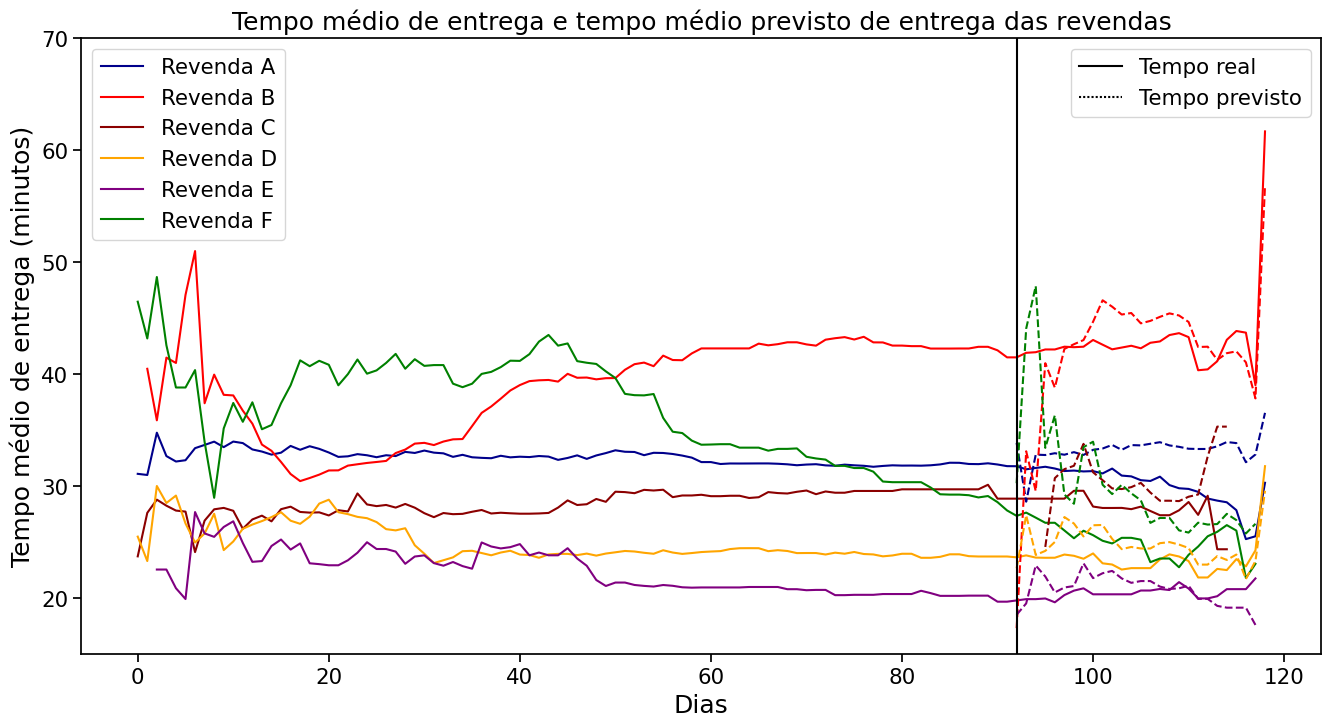

In [29]:
daily_prediction_averages_offset = [None] * offset_days_diff

plt.figure(figsize=(16, 8))
sns.set(style=None, font_scale=1.4)

sns.lineplot(data = daily_averages['A'], label = 'Revenda A', color=colors[0])
sns.lineplot(data = daily_averages['B'], label = 'Revenda B', color=colors[1])
sns.lineplot(data = daily_averages['C'], label = 'Revenda C', color=colors[2])
sns.lineplot(data = daily_averages['D'], label = 'Revenda D', color=colors[3])
sns.lineplot(data = daily_averages['E'], label = 'Revenda E', color=colors[4])
sns.lineplot(data = daily_averages['F'], label = 'Revenda F', color=colors[5])

sns.lineplot(data = (daily_prediction_averages_offset + daily_prediction_averages['A']), color=colors[0], linestyle="--")
sns.lineplot(data = (daily_prediction_averages_offset + daily_prediction_averages['B']), color=colors[1], linestyle="--")
sns.lineplot(data = (daily_prediction_averages_offset + daily_prediction_averages['C']), color=colors[2], linestyle="--")
sns.lineplot(data = (daily_prediction_averages_offset + daily_prediction_averages['D']), color=colors[3], linestyle="--")
sns.lineplot(data = (daily_prediction_averages_offset + daily_prediction_averages['E']), color=colors[4], linestyle="--")
sns.lineplot(data = (daily_prediction_averages_offset + daily_prediction_averages['F']), color=colors[5], linestyle="--")

plt.vlines(offset_days_diff,0,90,color='black')

plt.title("Tempo médio de entrega e tempo médio previsto de entrega das revendas", fontsize = 18)
plt.legend(fontsize = 16)
plt.ylabel('Tempo médio de entrega (minutos)', fontsize = 18)
plt.xlabel('Dias',fontsize = 18)

plt.ylim([15, 70])

line = Line2D([0,1],[0,1],linestyle='-', color='black')
dot = Line2D([0,1],[0,1],linestyle=(0, (1, 1)), color='black')
helper_legend = plt.legend([line, dot], ['Tempo real', 'Tempo previsto'], loc=1)

plt.legend([
    Line2D([0,1],[0,1],linestyle='-', color=colors[0]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[1]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[2]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[3]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[4]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[5])],
    ['Revenda A', 'Revenda B', 'Revenda C', 'Revenda D', 'Revenda E', 'Revenda F'], loc=0)

plt.gca().add_artist(helper_legend)

plt.show()

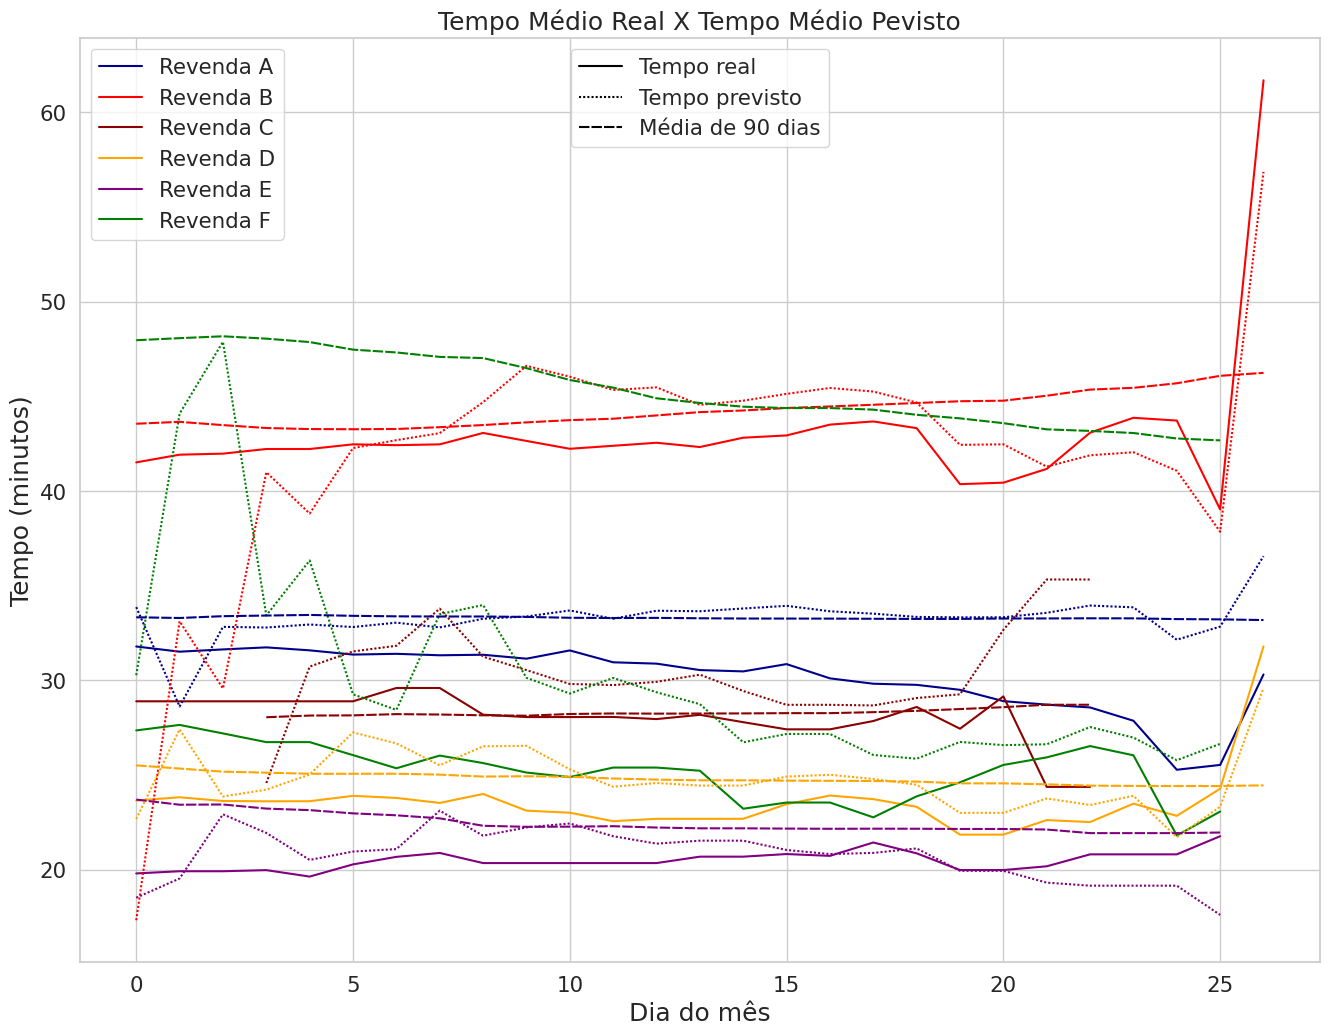

In [30]:
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid", font_scale=1.4)

sns.lineplot(data = daily_averages['A'][offset_days_diff:], color=colors[0])
sns.lineplot(data = daily_averages['B'][offset_days_diff:], color=colors[1])
sns.lineplot(data = daily_averages['C'][offset_days_diff:], color=colors[2])
sns.lineplot(data = daily_averages['D'][offset_days_diff:], color=colors[3])
sns.lineplot(data = daily_averages['E'][offset_days_diff:], color=colors[4])
sns.lineplot(data = daily_averages['F'][offset_days_diff:], color=colors[5])

sns.lineplot(data = daily_prediction_averages['A'], color=colors[0], linestyle=(0, (1, 1)))
sns.lineplot(data = daily_prediction_averages['B'], color=colors[1], linestyle=(0, (1, 1)))
sns.lineplot(data = daily_prediction_averages['C'], color=colors[2], linestyle=(0, (1, 1)))
sns.lineplot(data = daily_prediction_averages['D'], color=colors[3], linestyle=(0, (1, 1)))
sns.lineplot(data = daily_prediction_averages['E'], color=colors[4], linestyle=(0, (1, 1)))
sns.lineplot(data = daily_prediction_averages['F'], color=colors[5], linestyle=(0, (1, 1)))

sns.lineplot(data = average_delivery_times['A'], color=colors[0], linestyle=(0, (5, 1)))
sns.lineplot(data = average_delivery_times['B'], color=colors[1], linestyle=(0, (5, 1)))
sns.lineplot(data = average_delivery_times['C'], color=colors[2], linestyle=(0, (5, 1)))
sns.lineplot(data = average_delivery_times['D'], color=colors[3], linestyle=(0, (5, 1)))
sns.lineplot(data = average_delivery_times['E'], color=colors[4], linestyle=(0, (5, 1)))
sns.lineplot(data = average_delivery_times['F'], color=colors[5], linestyle=(0, (5, 1)))

plt.title("Tempo Médio Real X Tempo Médio Pevisto", fontsize = 18)
plt.legend(fontsize = 16)

line = Line2D([0,1],[0,1],linestyle='-', color='black')
dot = Line2D([0,1],[0,1],linestyle=(0, (1, 1)), color='black')
dash = Line2D([0,1],[0,1],linestyle=(0, (5, 1)), color='black')

helper_legend = plt.legend([line, dot, dash], ['Tempo real', 'Tempo previsto', 'Média de 90 dias'], loc=9)

plt.legend([
    Line2D([0,1],[0,1],linestyle='-', color=colors[0]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[1]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[2]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[3]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[4]),
    Line2D([0,1],[0,1],linestyle='-', color=colors[5])],
    ['Revenda A', 'Revenda B', 'Revenda C', 'Revenda D', 'Revenda E', 'Revenda F'], loc=0)

plt.gca().add_artist(helper_legend)

plt.ylabel('Tempo (minutos)', fontsize = 18)
plt.xlabel('Dia do mês',fontsize = 18)
plt.show()

# Resultados

Treino e previsão

In [31]:
mapes = {}
maes = {}
averages = {}

resellers = dataset.reseller.unique().tolist()

date_range = date_ranges[-1]
fit_start = get_date(date_range["fit_start"])
fit_end = get_date(date_range["fit_end"])
predict_start = get_date(date_range["predict_start"])
predict_end = get_date(date_range["predict_end"])

date_diff = (predict_end - predict_start).days

df_fit = dataset[
    (dataset["datetime"] >= fit_start) & (dataset["datetime"] < fit_end)
]

xfit = df_fit[x_columns]
yfit = df_fit[y_columns]

extra_trees_regressor = regressors["extra_trees"].best_estimator_
random_forest_regressor = regressors["random_forest"].best_estimator_
grad_boosting_regressor = regressors["grad_boosting"].best_estimator_

extra_trees_regressor.fit(xfit, yfit)
random_forest_regressor.fit(xfit, yfit)
grad_boosting_regressor.fit(xfit, yfit)

for reseller in resellers:
    predictions[reseller] = {'extra_trees': [], 'grad_boosting': [], 'random_forest': []}
    mapes[reseller] = {'extra_trees': [], 'grad_boosting': [], 'random_forest': []}
    maes[reseller] = {'extra_trees': [], 'grad_boosting': [], 'random_forest': []}

    for i in range(date_diff + 1):
        start_date = predict_start + timedelta(days=i)
        end_date = start_date + timedelta(days=i+1)

        df_filter = (dataset["datetime"] >= start_date) & (dataset["datetime"] < end_date) & (dataset["reseller"] == reseller)
        df_predict = dataset[df_filter]

        if df_predict.shape[0] == 0:
            predictions[reseller]['random_forest'].append(None)
            predictions[reseller]['extra_trees'].append(None)
            predictions[reseller]['grad_boosting'].append(None)
            continue

        xpredict = df_predict[x_columns]
        ypredict = df_predict[y_columns]

        extra_trees_prediction = extra_trees_regressor.predict(xpredict)
        random_forest_prediction = random_forest_regressor.predict(xpredict)
        grad_boosting_prediction = grad_boosting_regressor.predict(xpredict)

        predictions[reseller]['random_forest'].append(np.mean(random_forest_prediction))
        mapes[reseller]['random_forest'].append(mean_absolute_percentage_error(ypredict, random_forest_prediction))
        maes[reseller]['random_forest'].append(mean_absolute_error(ypredict, random_forest_prediction))

        predictions[reseller]['extra_trees'].append(np.mean(extra_trees_prediction))
        mapes[reseller]['extra_trees'].append(mean_absolute_percentage_error(ypredict, extra_trees_prediction))
        maes[reseller]['extra_trees'].append(mean_absolute_error(ypredict, extra_trees_prediction))

        predictions[reseller]['grad_boosting'].append(np.mean(grad_boosting_prediction))
        mapes[reseller]['grad_boosting'].append(mean_absolute_percentage_error(ypredict, grad_boosting_prediction))
        maes[reseller]['grad_boosting'].append(mean_absolute_error(ypredict, grad_boosting_prediction))

Processamento de métricas

In [32]:
extra_trees_mapes = []
random_forest_mapes = []
grad_boosting_mapes = []

extra_trees_maes = []
random_forest_maes = []
grad_boosting_maes = []

extra_trees_mapes_by_reseller = {}
random_forest_mapes_by_reseller = {}
grad_boosting_mapes_by_reseller = {}

extra_trees_maes_by_reseller = {}
random_forest_maes_by_reseller = {}
grad_boosting_maes_by_reseller = {}

for reseller in resellers:
    extra_trees_mapes_by_reseller[reseller] = np.mean(mapes[reseller]['extra_trees'])
    random_forest_mapes_by_reseller[reseller] = np.mean(mapes[reseller]['random_forest'])
    grad_boosting_mapes_by_reseller[reseller] = np.mean(mapes[reseller]['grad_boosting'])

    extra_trees_maes_by_reseller[reseller] = np.mean(maes[reseller]['extra_trees'])
    random_forest_maes_by_reseller[reseller] = np.mean(maes[reseller]['random_forest'])
    grad_boosting_maes_by_reseller[reseller] = np.mean(maes[reseller]['grad_boosting'])

for reseller in resellers:
    extra_trees_mapes.append(extra_trees_mapes_by_reseller[reseller])
    random_forest_mapes.append(random_forest_mapes_by_reseller[reseller])
    grad_boosting_mapes.append(grad_boosting_mapes_by_reseller[reseller])

    extra_trees_maes.append(extra_trees_maes_by_reseller[reseller])
    random_forest_maes.append(random_forest_maes_by_reseller[reseller])
    grad_boosting_maes.append(grad_boosting_maes_by_reseller[reseller])

In [33]:
metrics_average = pd.DataFrame({
    'Regressor': ['Extra Trees', 'Random Forest', 'Gradient Boosting'],
    'M.A.PE': [np.mean(extra_trees_mapes), np.mean(random_forest_mapes), np.mean(grad_boosting_mapes)],
    'M.A.E': [np.mean(extra_trees_maes), np.mean(random_forest_maes), np.mean(grad_boosting_maes)]
})

metrics_average

,Regressor,M.A.PE,M.A.E
0,Extra Trees,0.202066,5.080169
1,Random Forest,0.207090,5.172653
2,Gradient Boosting,0.213725,5.264504
